## Problem

Sebuah perusahaan memiliki kinerja yang baik apabila karyawan pada perusahaan memiliki kondisi yang puas atas pekerjaannya dan sebaliknya jika karyawan tidak puas akan pekerjaannya maka akan membuat performa perusahaan turun. Maka dari itu untuk mencegah agar perushaan dari performa yang buruk diperlukan model untuk mengetahui tingkat kepuasaan karyawan terhadap pekerjaannya.

## Goals

- Dapat memprediksi dan klasifikasi tingkat kepuasaan karyawan
- Meningkatkan performa perusahaan dengan mengambil langkah untuk karyawan yang tidak puas

## Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, plot_confusion_matrix


from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Data Collection

In [91]:
df = pd.read_csv('satisfaction.csv', index_col=0)

In [6]:
df.head()

,emp_id,age,Dept,location,education,recruitment_type,job_level,rating,onsite,awards,certifications,salary,satisfied
0,HR8270,28,HR,Suburb,PG,Referral,5,2,0,1,0,86750,1
1,TECH1860,50,Technology,Suburb,PG,Walk-in,3,5,1,2,1,42419,0
2,TECH6390,43,Technology,Suburb,UG,Referral,4,1,0,2,0,65715,0
3,SAL6191,44,Sales,City,PG,On-Campus,2,3,1,0,0,29805,1
4,HR6734,33,HR,City,UG,Recruitment Agency,2,1,0,5,0,29805,1


## Describe Data

In [7]:
df.shape

(500, 13)

Pada dataset terdapat 500 data karyawan serta terdapat 13 kolom

In [8]:
dfDesc = [] #mengetahui kolom pada dataset

for i in df.columns:
    dfDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum()) / (len(df))) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

In [9]:
pd.DataFrame(dfDesc, columns = ['Data Features', 'Data Type', 'Null', 'Null (%)', 'Unique', 'Unique Sample'])

,Data Features,Data Type,Null,Null (%),Unique,Unique Sample
0,emp_id,object,0,0.0,499,"[HR1098, SAL9319]"
1,age,int64,0,0.0,32,"[49, 50]"
2,Dept,object,0,0.0,5,"[Purchasing, Technology]"
3,location,object,0,0.0,2,"[City, Suburb]"
4,education,object,0,0.0,2,"[UG, PG]"
5,recruitment_type,object,0,0.0,4,"[Recruitment Agency, Walk-in]"
6,job_level,int64,0,0.0,5,"[1, 2]"
7,rating,int64,0,0.0,5,"[5, 3]"
8,onsite,int64,0,0.0,2,"[0, 1]"
9,awards,int64,0,0.0,10,"[0, 8]"


Kolom pada dataset mengindikasikan :
- **emp_id** merupakan id dari karyawan
- **age** merupakan umur dari karyawan
- **Dept** merupakan departement karyawan bekerja
- **location** merupakan lokasi kerja karyawan
- **education** merupakan jenjang pendidikan karyawan
- **recruitmrnt_type** merupakan jalur karyawan masuk pada perusahaan
- **job_level** merupakan tingkat pekerjaan atau jenjang pekerjaan karyawan
- **rating** merupakan tingkat penilaian karyawan pada periode sebelumnya
- **onsite** merupakan pernah tidaknya karyawan pergi pada lokasi kerjanya
- **awards** merupakan banyak penghargaan pada karyawan
- **certification** merupakan apakah karyawan memiliki sertifikat tidaknya
- **salary** merupakan gaji karyawan
- **satisfied** kepuasaan karyawan pada pekerjaannya

Dan diketahui juga bahwa :
- pada dataset tidak terdapat sebuah null atau missing value
- terdapat data karyawan yang sama dindikasikan dengan jumlah unique sample yang seharusnya 500 namun 499 sehingga terdapat 1 data yang sama

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,500.0,38.610,9.438648,23.0,30.0,39.0,47.0,54.0
job_level,500.0,3.032,1.423738,1.0,2.0,3.0,4.0,5.0
rating,500.0,3.072,1.425089,1.0,2.0,3.0,4.0,5.0
onsite,500.0,0.466,0.499342,0.0,0.0,0.0,1.0,1.0
awards,500.0,4.538,2.853215,0.0,2.0,5.0,7.0,9.0
certifications,500.0,0.496,0.500485,0.0,0.0,0.0,1.0,1.0
salary,500.0,50416.056,23671.392661,24076.0,29805.0,42419.0,65715.0,86750.0
satisfied,500.0,0.526,0.499824,0.0,0.0,1.0,1.0,1.0


In [11]:
df.describe(include='O').T

,count,unique,top,freq
emp_id,500,499,MKT7287,2
Dept,500,5,Purchasing,109
location,500,2,City,259
education,500,2,PG,254
recruitment_type,500,4,On-Campus,133


- dapat diberi hipotesa sementara bahwa tidak terdapat outliers dikarenakan Q3 dengan Max dan Q1 dengan Min interval untuk setiap kolom tidak berbeda jauh
- terdapat data yang sama yaitu MKT7287

In [12]:
df[df['emp_id'] == 'MKT7287']

,emp_id,age,Dept,location,education,recruitment_type,job_level,rating,onsite,awards,certifications,salary,satisfied
188,MKT7287,41,Marketing,City,UG,Referral,2,5,0,0,1,29805,1
215,MKT7287,50,Marketing,City,PG,Referral,2,2,0,1,0,29805,0


Ternyata walaupun id sama namun isian datanya berbeda

## Exploratory Data Analysis

#### *Handling Outliers and Imbalance Data*

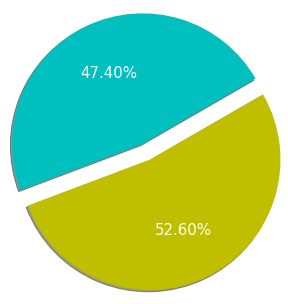

In [13]:
persentase = [df[df['satisfied'] == 0]['satisfied'].count(), df[df['satisfied'] == 1]['satisfied'].count()]
nama = [0, 1]

plt.pie(
    persentase,
    labels=nama,
    colors=['c','y'],
    startangle=30,
    shadow=True,
    radius=1.5,
    textprops={
        'size' : 15,
        'color' : 'w'
    },
    autopct='%1.2f%%',
    explode=(.1, .1)
    )
plt.show()

In [14]:
df.satisfied.value_counts()

1    263
0    237
Name: satisfied, dtype: int64

Terlihat bahwa kolom target memiliki porsi yang berimbang atau bukan merupaka imbalance data

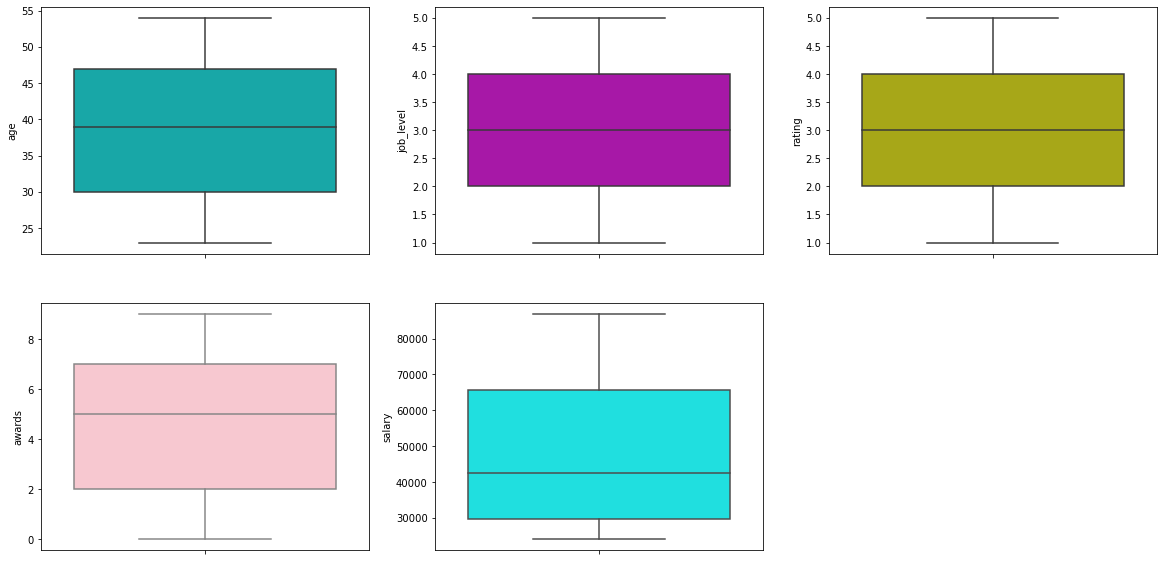

In [15]:
plt.figure(figsize=(20,10))

plt.subplot(231)
sns.boxplot(y=df['age'], color='c')

plt.subplot(232)
sns.boxplot(y=df['job_level'], color='m')

plt.subplot(233)
sns.boxplot(y=df['rating'], color='y')

plt.subplot(234)
sns.boxplot(y=df['awards'], color='pink')

plt.subplot(235)
sns.boxplot(y=df['salary'], color='aqua')



plt.show()

Terlihat pada tiap kolom tidak terdapat ouliers

#### *Data Analysis*

In [16]:
pd.crosstab(df.satisfied,df.recruitment_type, normalize='columns')*100

recruitment_type,On-Campus,Recruitment Agency,Referral,Walk-in
satisfied,,,,
0,45.864662,45.37037,48.091603,50.0
1,54.135338,54.62963,51.908397,50.0


- Proses pada perekrutan karyawan tidak menjamin puas atau tidaknya karyawan tersebut terbukti dengan bahwa persentase untuk yang puas dengan tidak hampir sama untuk setiap kolom atau seperti coin probability, namun ada memiliki pengaruh dibagian on-campus dan Recruitment_agency dengan banyak yang lebih puas

In [17]:
pd.crosstab(df.satisfied, df.Dept, normalize='columns')*100

Dept,HR,Marketing,Purchasing,Sales,Technology
satisfied,,,,,
0,50.0,53.684211,43.119266,44.565217,45.918367
1,50.0,46.315789,56.880734,55.434783,54.081633


- Deptarement HR tidak mempengaruhi suatu kepuasaan karyawan terhadap pekerjaannya seperti coin toss atau coin probability
- untuk yang lain memiliki pengaruh namun sedikit

In [18]:
pd.crosstab(df.satisfied, df.education, normalize='columns')*100

education,PG,UG
satisfied,,
0,46.062992,48.780488
1,53.937008,51.219512


- Sama seperti sebelumnya pendidikan tidak mempengaruhi kepuasaan pada karyawan

In [19]:
pd.crosstab(df.satisfied, df.location, normalize='columns')*100

location,City,Suburb
satisfied,,
0,45.945946,48.962656
1,54.054054,51.037344


- terlihat persentase kepuasaan terhadap location sedikit mempengaruhi tingkat kepuasaan karyawan terhdfapa pekerjaannya

#### *Data Visualization*

In [20]:
df.head()

,emp_id,age,Dept,location,education,recruitment_type,job_level,rating,onsite,awards,certifications,salary,satisfied
0,HR8270,28,HR,Suburb,PG,Referral,5,2,0,1,0,86750,1
1,TECH1860,50,Technology,Suburb,PG,Walk-in,3,5,1,2,1,42419,0
2,TECH6390,43,Technology,Suburb,UG,Referral,4,1,0,2,0,65715,0
3,SAL6191,44,Sales,City,PG,On-Campus,2,3,1,0,0,29805,1
4,HR6734,33,HR,City,UG,Recruitment Agency,2,1,0,5,0,29805,1


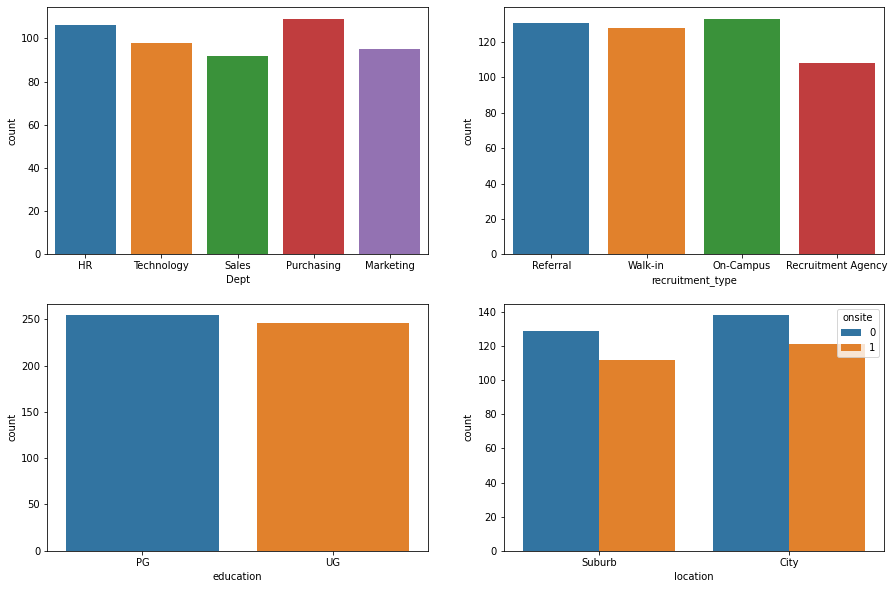

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(221)
sns.countplot(x='Dept', data=df)

plt.subplot(222)
sns.countplot(x='recruitment_type', data=df)

plt.subplot(223)
sns.countplot(x='education', data=df)

plt.subplot(224)
sns.countplot(x='location', data=df, hue='onsite')

plt.show()

Terlihat dari grafik diatas bahwa:
- jumlah dept, recruitment, education, dan location berimbang untuk setiap data yang berbeda
- dapat diketahui bahwa banyak karyawan yang tidak pergi ke lokasi pekerjaan dibanding tidak pergi namun tidak terlalu signifikan perbedaannya

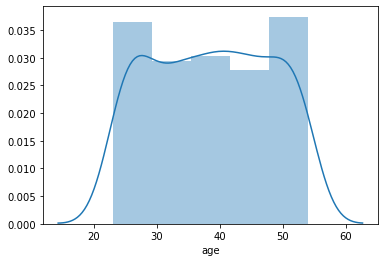

In [22]:
sns.distplot(df.age, bins=5)
plt.show()

Terlihat bahwa persebaran umur karyawan dengan banyak rentang karyawan berumur sekitar 30 sampai 50 tahun dan persebaran umurnya merata

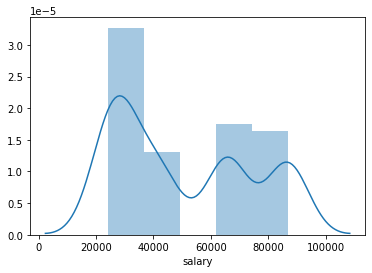

In [23]:
sns.distplot(df.salary, bins=5)
plt.show()

- Karyawan banyak yang mendapatkan gaji sekitar 20000 sampai dengan 40000
- Terdapat juga banyak karyawan yang memiliki gaji sekitar 60000 sampai sekitar 90000 namun tak sebanyak yang diatas

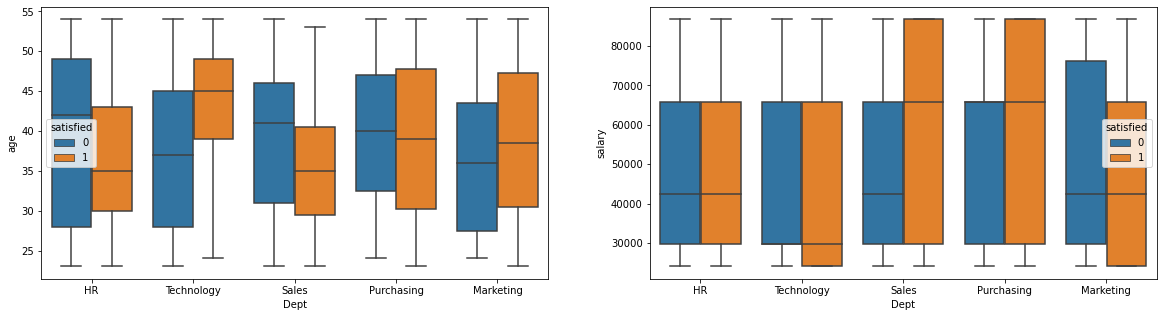

In [24]:
plt.figure(figsize=(20,5))

plt.subplot(121)
sns.boxplot(y='age', x='Dept', data=df, hue='satisfied')

plt.subplot(122)
sns.boxplot(y='salary', x='Dept', data=df, hue='satisfied')

plt.show()

- Terlihat bahwa perbedaan untuk umur dan dept setiap kepuasaan pada karyawan
- Untuk gaji tiap dept hampir sama namun terlihat pada marketing terdapa karyawan yang tidak puas memiliki gaji diatas rerata

Terlihat untuk tingkat kepuasan karyawan terhadap pekerjaan jika dibandingkan dengan feature satu satu tidak begitu tampak namun jika digabungkan dengan feature yang lain terdapat pengaruh terhadap tingkat kepuasan karyawan

## Data Preprocessing

#### *Feature Engineering*

In [25]:
df.drop(columns=['emp_id'], inplace=True)

In [26]:
df.head()

,age,Dept,location,education,recruitment_type,job_level,rating,onsite,awards,certifications,salary,satisfied
0,28,HR,Suburb,PG,Referral,5,2,0,1,0,86750,1
1,50,Technology,Suburb,PG,Walk-in,3,5,1,2,1,42419,0
2,43,Technology,Suburb,UG,Referral,4,1,0,2,0,65715,0
3,44,Sales,City,PG,On-Campus,2,3,1,0,0,29805,1
4,33,HR,City,UG,Recruitment Agency,2,1,0,5,0,29805,1


In [27]:
df['location'] = df['location'].map({'Suburb' : 0, 'City' : 1})
df['education'] = df['education'].map({'UG' : 0, 'PG' : 1})

In [28]:
pd.DataFrame([['Suburb', 'UG',], ['City', 'PG']], columns=['location', 'education'])

,location,education
0,Suburb,UG
1,City,PG


mengubah isi kolom location dan education dengan keterangan diatas atau encoding

In [29]:
df = pd.get_dummies(data=df, columns=['Dept'])
df = pd.get_dummies(data=df, columns=['recruitment_type'])

membuat one hot encode pada kolom dept dan recruitment type

In [30]:
df.head()

,age,location,education,job_level,rating,onsite,awards,certifications,salary,satisfied,Dept_HR,Dept_Marketing,Dept_Purchasing,Dept_Sales,Dept_Technology,recruitment_type_On-Campus,recruitment_type_Recruitment Agency,recruitment_type_Referral,recruitment_type_Walk-in
0,28,0,1,5,2,0,1,0,86750,1,1,0,0,0,0,0,0,1,0
1,50,0,1,3,5,1,2,1,42419,0,0,0,0,0,1,0,0,0,1
2,43,0,0,4,1,0,2,0,65715,0,0,0,0,0,1,0,0,1,0
3,44,1,1,2,3,1,0,0,29805,1,0,0,0,1,0,1,0,0,0
4,33,1,0,2,1,0,5,0,29805,1,1,0,0,0,0,0,1,0,0


#### *Data Splitting*

In [31]:
x = df.drop(columns=['satisfied'])
y = df.satisfied

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = .2, random_state=42)

In [33]:
x_train.head()

,age,location,education,job_level,rating,onsite,awards,certifications,salary,Dept_HR,Dept_Marketing,Dept_Purchasing,Dept_Sales,Dept_Technology,recruitment_type_On-Campus,recruitment_type_Recruitment Agency,recruitment_type_Referral,recruitment_type_Walk-in
256,49,1,0,4,1,1,7,0,65715,0,0,1,0,0,0,0,0,1
292,40,0,0,2,1,0,9,0,29805,0,0,0,0,1,0,0,0,1
387,35,1,0,5,3,0,8,0,86750,0,0,0,1,0,1,0,0,0
102,28,0,1,5,5,0,5,0,86750,0,0,1,0,0,1,0,0,0
54,32,0,0,4,4,1,0,0,65715,0,0,0,1,0,0,0,0,1


In [34]:
y_train.head()

256    0
292    0
387    1
102    1
54     1
Name: satisfied, dtype: int64

Terlihat bahwa data sudah di splitting dengan porsi satisfied yang merata dengan test

#### *Scalling*

In [35]:
scaler = RobustScaler()

In [36]:
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [37]:
pd.DataFrame(x_train_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.6250,0.0,0.0,0.5,-1.0,1.0,0.4,0.0,0.648733,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0625,-1.0,0.0,-0.5,-1.0,0.0,0.8,0.0,-0.351267,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.2500,0.0,0.0,1.0,0.0,0.0,0.6,0.0,1.234503,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-0.6875,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.234503,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.4375,-1.0,0.0,0.5,0.5,1.0,-1.0,0.0,0.648733,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.1250,-1.0,1.0,-0.5,0.5,0.0,-1.0,1.0,-0.351267,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
396,0.2500,0.0,1.0,-1.0,-1.0,0.0,0.8,0.0,-0.510805,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
397,-1.0000,0.0,0.0,-0.5,1.0,0.0,0.6,0.0,-0.351267,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
398,0.5625,-1.0,1.0,-0.5,0.5,0.0,0.2,0.0,-0.351267,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


terlihat bahwa data sudah di scalling menggunakan robust scaler

## Modelling

#### *Logistic Regression*

In [38]:
model_log = LogisticRegression()

In [39]:
model_log.fit(x_train_scaled, y_train)

LogisticRegression()

In [40]:
y_pred_log = model_log.predict(x_test_scaled)

In [41]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.43      0.53      0.48        47
           1       0.48      0.38      0.42        53

    accuracy                           0.45       100
   macro avg       0.45      0.45      0.45       100
weighted avg       0.45      0.45      0.45       100



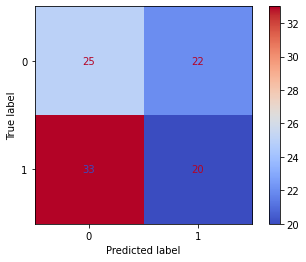

In [42]:
plot_confusion_matrix(model_log, x_test_scaled, y_test,cmap='coolwarm')
plt.show()

- Terlihat akurasi sangat buruk dibawah 0.5
- Precission 0 masih 0.43

#### *Support Vector Machine (SVM)*

In [43]:
model_svm = SVC()

In [44]:
model_svm.fit(x_train_scaled, y_train)

SVC()

In [45]:
y_pred_svm = model_svm.predict(x_test_scaled)

In [46]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.44      0.34      0.39        47
           1       0.52      0.62      0.56        53

    accuracy                           0.49       100
   macro avg       0.48      0.48      0.47       100
weighted avg       0.48      0.49      0.48       100



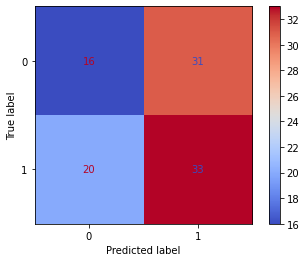

In [47]:
plot_confusion_matrix(model_svm, x_test_scaled, y_test,cmap='coolwarm')
plt.show()

- Terlihat akurasi sama seperti coin toss
- Precission 0 jelek berupa 0.44

#### *XGBoost*

In [48]:
model_xgb = XGBClassifier()

In [49]:
model_xgb.fit(x_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
y_pred_xgb = model_xgb.predict(x_test_scaled)

In [51]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52        47
           1       0.58      0.60      0.59        53

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100



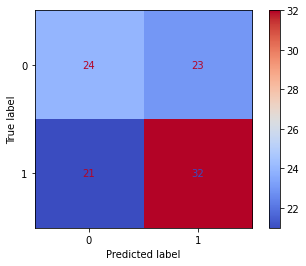

In [52]:
plot_confusion_matrix(model_xgb, x_test_scaled, y_test,cmap='coolwarm')
plt.show()

- Akiurasi masih buruk seperti coin toss
- Precission 0 masih 0.53

#### *SGD Classifier*

In [53]:
model_sgd = SGDClassifier()

In [54]:
model_sgd.fit(x_train_scaled, y_train)

SGDClassifier()

In [55]:
y_pred_sgd = model_sgd.predict(x_test_scaled)

In [56]:
print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

           0       0.44      0.30      0.35        47
           1       0.51      0.66      0.58        53

    accuracy                           0.49       100
   macro avg       0.48      0.48      0.47       100
weighted avg       0.48      0.49      0.47       100



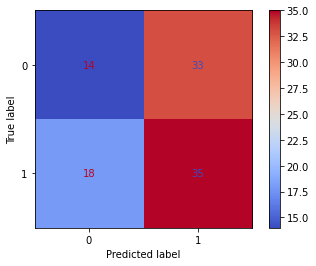

In [57]:
plot_confusion_matrix(model_sgd, x_test_scaled, y_test,cmap='coolwarm')
plt.show()

- Akurasi masih sangat rendah
- Precission buruk berupa 0.49

#### *Random Forest*

In [58]:
model_rf = RandomForestClassifier()

In [59]:
model_rf.fit(x_train_scaled, y_train)

RandomForestClassifier()

In [60]:
y_pred_rf = model_rf.predict(x_test_scaled)

In [61]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.49      0.62      0.55        47
           1       0.56      0.43      0.49        53

    accuracy                           0.52       100
   macro avg       0.53      0.53      0.52       100
weighted avg       0.53      0.52      0.52       100



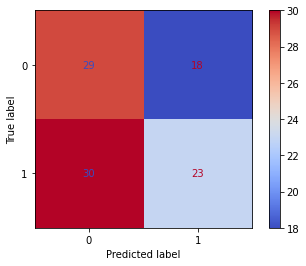

In [62]:
plot_confusion_matrix(model_rf, x_test_scaled, y_test,cmap='coolwarm')
plt.show()

- Akurasi buruk 0.51
- Precission buruk 0.48

## Hyper Parameter Tuning

#### *XGBoost*

In [63]:
param = {
"max_depth" : np.arange(1,11),
"learning_rate" : np.logspace(-2, 0, 3),
"n_estimator" : [100, 120, 150, 200],
"subsample" : [.3, .7, .8, 1],
"gamma" : np.arange(1, 11),
"colsample_bytree" : [.3, .7, .8, 1],
"reg_alpha" : np.logspace(-2, 0, 3),
"reg_lambda" : np.logspace(-2, 0, 3),
}

In [78]:
model_xgb_hp = RandomizedSearchCV(XGBClassifier(), param, cv = 5, n_jobs=3, verbose=1)
model_xgb_hp.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    3.6s finished


[14:22:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                          

In [79]:
model_xgb_hp.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 50}

In [80]:
y_pred_xgb_hp = model_xgb_hp.predict(x_test_scaled)

In [81]:
print(classification_report(y_test, y_pred_xgb_hp))

              precision    recall  f1-score   support

           0       0.50      0.53      0.52        47
           1       0.56      0.53      0.54        53

    accuracy                           0.53       100
   macro avg       0.53      0.53      0.53       100
weighted avg       0.53      0.53      0.53       100



#### *Random Forest*

In [65]:
RandomForestClassifier()

RandomForestClassifier()

In [66]:
param = {
'max_depth': [10, 50, 100, None],
'min_samples_leaf': [1, 2, 4],
'min_samples_split': [2, 5, 10],
'n_estimators': [100, 1000, 1500, 2000]
}

In [67]:
model_rf_hp = GridSearchCV(model_rf, param, cv = 5, n_jobs=-1, verbose=1)
model_rf_hp.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.6min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 50, 100, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 1000, 1500, 2000]},
             verbose=1)

In [68]:
model_rf_hp.best_params_

{'max_depth': 100,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [69]:
y_pred_rf_hp = model_rf_hp.predict(x_test_scaled)

In [74]:
print(classification_report(y_test, y_pred_rf_hp))

              precision    recall  f1-score   support

           0       0.44      0.51      0.48        47
           1       0.50      0.43      0.46        53

    accuracy                           0.47       100
   macro avg       0.47      0.47      0.47       100
weighted avg       0.47      0.47      0.47       100



#### *SVM*

In [ ]:
SVC()

In [85]:
param = {
"C" : [0.1, 0.5, 1],
"gamma" : np.logspace(-3, 3, 7),
}

In [93]:
model_svm_hp = GridSearchCV(SVC(), param, cv = 5, n_jobs=-1, verbose=1)
model_svm_hp.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  82 out of 105 | elapsed:    1.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    1.6s finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1],
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             verbose=1)

In [94]:
y_pred_svm_hp = model_svm_hp.predict(x_test_scaled)

In [95]:
print(classification_report(y_test, y_pred_rf_hp))

              precision    recall  f1-score   support

           0       0.44      0.51      0.48        47
           1       0.50      0.43      0.46        53

    accuracy                           0.47       100
   macro avg       0.47      0.47      0.47       100
weighted avg       0.47      0.47      0.47       100



Terlihat bahwa untuk semua algoritma hasil data untuk evaluation matrix dan classification report hampir sama dengan seperti pada coin toss probability

## Kesimpulan

Data tidak dapat digunakan untuk memprediksi tingkat kepuasan dari karyawan karena memiliki precision dan Akurasi yang sama dengan coin toss

## Saran

- Jikalau data dapat memprediksi kepuasan karyawan maka dari model tersebut digunakan untuk memprediksi karyawan yang tidak puas untuk selanjutnya perusahaan dapat melakukan mentoring pada karyawan atau dipindah tugaskan departement, atau bahkan dapat memberikan gaji yang lebih terhadap karyawan
- Untuk karyawan yang sudah berumur tua dan tidak puas sebaiknya perusahaan dapat memberitahukan kepada karyawan tersebut untuk berhenti

In [96]:
import joblib

In [97]:
joblib.dump(model_xgb,'model_exam')

['model_exam']